In [1]:
import pandas as pd
import numpy as np
import alphalens
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass
import empyrical

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.chdir('../')

In [4]:
matplotlib.rcParams['font.sans-serif'] = ['Times New Roman'] 

#### 1.导入数据

In [6]:
# alpha = pd.read_csv('./Output/alpha_daily_return(5%Significance).csv',index_col = 0)
alpha = pd.read_excel('./Output/alpha(Improved).xlsx',index_col = 0)
alpha.index = pd.to_datetime(alpha.index)

In [7]:
# 导入净值数据
# 基金数据，并分类到股票型基金
nv_2010to2014 = pd.read_csv("./Data/AdjustedNav(2010to2014).csv",index_col = 0)
nv_2015to2018 = pd.read_csv("./Data/AdjustedNav(2015to2018).csv",index_col = 0)
nv_2019to2022 = pd.read_csv("./Data/AdjustedNav(2019to2022).csv",index_col = 0)

In [8]:
nv = pd.concat([nv_2010to2014,nv_2015to2018,nv_2019to2022])

In [9]:
nv.index = pd.to_datetime(nv.index)

In [10]:
filled_nv = nv.asfreq("D").ffill()

In [11]:
# 导入基金经理离任数据
manager_info = pd.read_csv("./Data/ChinaMutualFundManager.csv",encoding = "gbk")

In [12]:
# 导入货币市场基金，不买货币市场基金
# 导入股票型、偏股型和灵活配置型基金
currency_fund = pd.read_excel("./Data/CurrencyFund.xlsx",index_col = 0)
stk_mutual_fund = pd.read_excel("./Data/StkMutualFundInfo.xlsx",index_col = 0)

In [13]:
# stk_mutual_fund.query("FUND_TYPE == '普通股票型基金' or FUND_TYPE == '偏股混合型基金'",inplace = True)

#### 2.回测

In [14]:
@dataclass
class FundClass:
    vt_symbol:str = " "
    buy_price:float = 0.0
    volume:int = 0
        
    def __post_init__(self):
        self.price = self.buy_price
        self.last_price = self.buy_price
        self.pnl = (self.price - self.buy_price)*self.volume
        self.daily_pnl = (self.price - self.last_price)*self.volume
        self.status = "HOLDING"

In [15]:
"""variables"""

"""paramaters"""
start_date = pd.to_datetime("2014-03-31")
end_date = pd.to_datetime("2021-12-31")
buy_cost:float = 0.005
sell_cost:float = 0.005
"""account infomation"""
in_position_fund:dict = {} 
balance:float = 300000.0
backtest_result:pd.DataFrame = pd.DataFrame(columns = ["ACCOUNT_NAV"])

In [16]:
for date in pd.date_range(start_date,end_date): # 每天都进行循环更新
    
    if date in alpha.index and date.month % 3 == 0:
        # seasonal adjustment
        to_buy_position = alpha.loc[date].dropna().sort_values(ascending = False).iloc[:int(len(alpha.loc[date].dropna())*0.1)]
        # clear
        for to_sell_fund in in_position_fund.keys():
            # update when at the end of the month
            in_position_fund[to_sell_fund].last_price = in_position_fund[to_sell_fund].price
            in_position_fund[to_sell_fund].price = filled_nv.at[date,to_sell_fund]
            in_position_fund[to_sell_fund].pnl = (in_position_fund[to_sell_fund].price - \
                                                  in_position_fund[to_sell_fund].buy_price)*in_position_fund[to_sell_fund].volume
            in_position_fund[to_sell_fund].daily_pnl = (in_position_fund[to_sell_fund].price - \
                                                        in_position_fund[to_sell_fund].last_price)*in_position_fund[to_sell_fund].volume
            # sell
            if to_sell_fund not in to_buy_position:
                sell_price = filled_nv.at[date,to_sell_fund]
                print(f"sell {to_sell_fund} at {sell_price}")
                in_position_fund[to_sell_fund].status = "SOLD"
        
        # adjust
        for to_adjust_fund in in_position_fund.keys():
            if in_position_fund[to_adjust_fund].status == "HOLDING":
                price = filled_nv.at[date,to_adjust_fund]
                target_volume = balance/len(to_buy_position)/(price*(1+sell_cost))
                present_volume = in_position_fund[to_adjust_fund].volume
                if target_volume > present_volume:
                    pass
                else:
                    balance += (present_volume - target_volume)*(price - in_position_fund[to_adjust_fund].last_price)
                    balance -= (present_volume - target_volume)*price*sell_cost # sell cost
                    in_position_fund[to_adjust_fund].volume = target_volume
                    in_position_fund[to_adjust_fund].pnl = (in_position_fund[to_adjust_fund].price - \
                                                            in_position_fund[to_adjust_fund].buy_price) * in_position_fund[to_adjust_fund].volume
                    in_position_fund[to_adjust_fund].daily_pnl = (in_position_fund[to_adjust_fund].price - \
                                                                  in_position_fund[to_adjust_fund].last_price) * in_position_fund[to_adjust_fund].volume
                    print(f"adjust {to_adjust_fund} from {present_volume} to {target_volume}")

        # buy: not currency fund, must be in stk mutual fund
        for to_buy_fund in to_buy_position.index:
            if to_buy_fund not in in_position_fund.keys() and to_buy_fund not in currency_fund.index and to_buy_fund in stk_mutual_fund.index:
                buy_price = filled_nv.at[date,to_buy_fund]
                in_position_fund[to_buy_fund] = FundClass(
                    vt_symbol = to_buy_fund,
                    buy_price = buy_price,
                    volume = balance/len(to_buy_position)/(buy_price*(1+buy_cost)),
                )
                balance -= buy_price*(balance/len(to_buy_position)/buy_price)*buy_cost # buy cost
                print(f"buy {to_buy_fund} at {buy_price}")
                
    else:
        # 平日更新
        for to_adjust_fund in in_position_fund.keys():
            price = filled_nv.at[date,to_adjust_fund]
            in_position_fund[to_adjust_fund].last_price = in_position_fund[to_adjust_fund].price
            in_position_fund[to_adjust_fund].price = price
            in_position_fund[to_adjust_fund].pnl = (in_position_fund[to_adjust_fund].price - \
                                                    in_position_fund[to_adjust_fund].buy_price)*in_position_fund[to_adjust_fund].volume
            in_position_fund[to_adjust_fund].daily_pnl = (in_position_fund[to_adjust_fund].price - \
                                                          in_position_fund[to_adjust_fund].last_price)*in_position_fund[to_adjust_fund].volume
            
    for to_compute_pnl_fund in list(in_position_fund.keys()):
        balance += in_position_fund[to_compute_pnl_fund].daily_pnl
        if in_position_fund[to_compute_pnl_fund].status == "SOLD":
            balance -= in_position_fund[to_compute_pnl_fund].price*in_position_fund[to_compute_pnl_fund].volume*sell_cost # sell cost
            del in_position_fund[to_compute_pnl_fund]
    backtest_result.loc[date,"ACCOUNT_NAV"] = balance

buy 000030.OF at 1.183
buy 470098.OF at 1.342
buy 163412.OF at 1.764
buy 340008.OF at 1.6123
buy 519979.OF at 1.4967
buy 000172.OF at 1.035
buy 959993.OF at 1.122
buy 160505.OF at 5.03407123
buy 000251.OF at 1.141
buy 420003.OF at 1.2285
buy 400007.OF at 1.3065
buy 180031.OF at 1.4808
buy 530011.OF at 0.927
buy 460002.OF at 0.9022372
buy 519035.OF at 2.57230286
buy 040016.OF at 0.9293
buy 160607.OF at 2.43523227
buy 165313.OF at 0.894
buy 202005.OF at 2.59401473
buy 210003.OF at 0.7772
buy 160916.OF at 0.8113
buy 163415.OF at 1.025
buy 519996.OF at 2.64508865
buy 519983.OF at 0.905
buy 630010.OF at 1.2795
buy 952009.OF at 1.1574972
buy 400001.OF at 2.63987537
buy 398031.OF at 1.7895
buy 163409.OF at 1.367
buy 000082.OF at 0.976
buy 161005.OF at 4.8301266
buy 213002.OF at 1.72468317
buy 519093.OF at 1.07
buy 090019.OF at 1.073
buy 519069.OF at 1.8472
buy 519087.OF at 3.64588054
buy 519994.OF at 1.56222933
buy 090001.OF at 3.85219555
buy 000165.OF at 1.0649
buy 519097.OF at 1.099
buy 200

sell 160607.OF at 4.48772733
sell 519087.OF at 7.60053498
sell 040016.OF at 1.9633
sell 519093.OF at 2.274
sell 000020.OF at 2.011
sell 000309.OF at 1.728
sell 519158.OF at 2.441
sell 260116.OF at 3.367
sell 952009.OF at 2.15685194
sell 000532.OF at 1.921
sell 000589.OF at 2.1182
sell 000574.OF at 2.6579
sell 210003.OF at 1.5029
sell 000572.OF at 1.284
sell 519150.OF at 3.1393
sell 000165.OF at 1.944
sell 770001.OF at 2.2375
sell 000251.OF at 2.757
sell 257050.OF at 1.896
sell 260104.OF at 10.6131257
sell 257030.OF at 2.19677917
sell 260109.OF at 5.13214555
sell 160910.OF at 2.7509082
sell 320006.OF at 3.73856795
sell 000824.OF at 1.8292
sell 090007.OF at 3.6548
sell 000825.OF at 1.8063
sell 540002.OF at 4.8237817
sell 200010.OF at 2.3432
sell 163415.OF at 2.245
sell 398041.OF at 1.4877
sell 090013.OF at 2.009
sell 376510.OF at 1.678
sell 260108.OF at 2.40824674
sell 020009.OF at 3.97385699
sell 165512.OF at 2.487
sell 161606.OF at 3.9895906
sell 020010.OF at 2.68324664
sell 112002.OF 

sell 163110.OF at 2.546
sell 200008.OF at 1.2167
sell 100060.OF at 2.634
sell 688888.OF at 1.658
sell 000520.OF at 1.7259
sell 240022.OF at 1.071
sell 000577.OF at 1.944
sell 550002.OF at 4.22309861
sell 460009.OF at 1.7158
sell 970016.OF at 1.81141275
sell 000279.OF at 2.203
sell 000362.OF at 1.92
sell 460005.OF at 4.53382614
sell 000363.OF at 1.924
sell 000390.OF at 2.1305
sell 169101.OF at 1.8617
sell 900010.OF at 2.78142274
sell 166801.OF at 2.554
sell 040035.OF at 3.9301
sell 000408.OF at 2.2522
sell 210003.OF at 1.6845
sell 000547.OF at 2.21
sell 000452.OF at 1.7989
sell 000963.OF at 1.361
sell 161219.OF at 2.78
sell 570008.OF at 2.303
sell 000339.OF at 1.458
sell 257020.OF at 7.32079189
sell 000354.OF at 2.0294
sell 000328.OF at 1.825
sell 519700.OF at 1.965
sell 090007.OF at 3.6113
sell 000926.OF at 1.144
sell 000308.OF at 2.22
sell 090013.OF at 1.981
sell 161224.OF at 1.233
sell 001070.OF at 1.284
sell 040015.OF at 2.3054
sell 000845.OF at 1.6749
sell 310328.OF at 4.37302683
s

sell 570005.OF at 2.43
sell 398041.OF at 1.3119
sell 001518.OF at 1.5753
sell 001074.OF at 0.8204
sell 161225.OF at 0.996
sell 001256.OF at 1.062
sell 001380.OF at 1.4893
sell 001272.OF at 1.401
sell 001495.OF at 1.0956
sell 420003.OF at 2.1863
sell 002085.OF at 1.171
sell 590003.OF at 2.4727
sell 001102.OF at 1.027
sell 001651.OF at 1.019
sell 001705.OF at 1.121
sell 001736.OF at 1.153
sell 519185.OF at 1.9457
sell 001437.OF at 1.327
sell 001438.OF at 1.094
sell 020003.OF at 8.30638731
sell 690007.OF at 1.871
sell 001638.OF at 0.938
sell 163110.OF at 2.372
sell 202019.OF at 1.437
sell 519191.OF at 0.9282
sell 001761.OF at 1.08
sell 161903.OF at 3.02806142
sell 000974.OF at 0.996
sell 160505.OF at 9.80146537
sell 001869.OF at 1.081
sell 001897.OF at 0.976
sell 000825.OF at 1.9194
sell 001103.OF at 1.025
sell 952009.OF at 2.10579272
sell 000755.OF at 1.4363
sell 229002.OF at 2.343
sell 233009.OF at 2.6497
sell 001060.OF at 1.034
sell 001635.OF at 1.006
sell 000652.OF at 1.5792
sell 0012

sell 000916.OF at 1.2957
sell 090018.OF at 2.3469
sell 270041.OF at 2.017
sell 000763.OF at 1.47
sell 270007.OF at 1.0592
sell 001471.OF at 1.096
sell 202005.OF at 5.50239935
sell 001278.OF at 1.0997
sell 002360.OF at 1.1047
sell 000991.OF at 0.987
sell 310328.OF at 3.77133857
sell 910028.OF at 2.2386
sell 519066.OF at 3.05543651
sell 001837.OF at 1.115
sell 002214.OF at 1.098
sell 001875.OF at 1.131
sell 000523.OF at 1.8338
sell 001371.OF at 1.016
sell 002653.OF at 1.061
sell 519994.OF at 3.07368092
sell 162607.OF at 3.89133324
sell 519736.OF at 1.848
sell 050018.OF at 1.007
sell 001682.OF at 1.071
sell 420003.OF at 2.4505
sell 920008.OF at 1.58144564
sell 001878.OF at 1.153
sell 000979.OF at 0.869
sell 020026.OF at 2.6455
sell 519606.OF at 1.4732
sell 001942.OF at 1.075
sell 260112.OF at 2.024
sell 519727.OF at 1.5221
sell 001943.OF at 1.069
sell 519133.OF at 1.102
sell 671010.OF at 0.854
sell 001120.OF at 0.6385
sell 519068.OF at 2.85818933
sell 160505.OF at 10.62534125
sell 519712.

sell 001104.OF at 1.022
sell 001662.OF at 1.068
sell 001938.OF at 1.5386
sell 540002.OF at 5.09956281
sell 000408.OF at 2.4081
sell 001643.OF at 0.9768
sell 001644.OF at 0.969
sell 001542.OF at 1.557
sell 180012.OF at 4.73335005
sell 001810.OF at 1.336
sell 001838.OF at 0.855
sell 001718.OF at 1.242
sell 001178.OF at 1.258
sell 002121.OF at 1.176
sell 001764.OF at 1.143
sell 003993.OF at 1.1857
sell 001878.OF at 1.435
sell 110022.OF at 1.904
sell 002332.OF at 1.1322
sell 002851.OF at 1.262
sell 002333.OF at 1.1259
sell 001837.OF at 1.291
sell 002387.OF at 1.053
sell 002443.OF at 1.2705
sell 001371.OF at 1.199
sell 002653.OF at 1.1843
sell 000017.OF at 2.2622
sell 310388.OF at 1.5609
sell 001874.OF at 1.089
sell 001875.OF at 1.262
sell 206007.OF at 1.932
sell 002860.OF at 1.047
sell 630011.OF at 2.2159
sell 001703.OF at 1.251
sell 001685.OF at 1.17
sell 160322.OF at 1.1603
sell 519710.OF at 1.4139
sell 001606.OF at 1.1682
sell 002214.OF at 1.281
sell 000854.OF at 1.432
sell 001712.OF at

sell 519091.OF at 2.673
sell 519195.OF at 1.6283
sell 001974.OF at 1.365
sell 519672.OF at 2.317
sell 002561.OF at 1.092
sell 001897.OF at 1.237
sell 519157.OF at 1.415
sell 519156.OF at 3.036
sell 001302.OF at 1.018
sell 002207.OF at 1.003
sell 001120.OF at 0.7187
sell 001121.OF at 0.7005
sell 162607.OF at 5.04104534
sell 160627.OF at 1.3657
sell 003858.OF at 1.098
sell 003857.OF at 1.1003
sell 002952.OF at 1.0765
sell 260101.OF at 10.09073243
sell 000926.OF at 0.9976
sell 240022.OF at 1.5932
sell 001733.OF at 1.128
sell 000219.OF at 1.5641
sell 519965.OF at 1.312
sell 001056.OF at 0.977
sell 003154.OF at 1.2058
sell 000688.OF at 1.4986
sell 002210.OF at 1.1983
sell 003865.OF at 1.1923
sell 001975.OF at 1.535
sell 000063.OF at 1.879
sell 110025.OF at 1.147
sell 003714.OF at 1.0758
sell 003713.OF at 1.0775
sell 001071.OF at 1.044
sell 001829.OF at 1.105
sell 004292.OF at 1.1615
sell 001839.OF at 1.082
sell 001244.OF at 1.2638
sell 001763.OF at 0.987
sell 001637.OF at 1.157
sell 160518.

sell 540006.OF at 3.5009
sell 960000.OF at 1.346
sell 001607.OF at 1.1902
sell 001608.OF at 1.0282
sell 000251.OF at 3.1127
sell 001392.OF at 1.1616
sell 001393.OF at 1.1432
sell 001359.OF at 1.1222
sell 001654.OF at 1.1151
sell 000877.OF at 1.7223
sell 001305.OF at 0.692
sell 003175.OF at 1.2547
sell 000849.OF at 2.0916
sell 000850.OF at 2.0978
sell 090018.OF at 2.3221
sell 000991.OF at 1.247
sell 730002.OF at 1.6073
sell 001283.OF at 1.1884
sell 001284.OF at 1.1056
sell 004091.OF at 1.2309
sell 004092.OF at 1.2266
sell 001208.OF at 1.115
sell 002214.OF at 1.5847
sell 002849.OF at 1.02
sell 000969.OF at 1.126
sell 004212.OF at 1.1129
sell 004224.OF at 0.839
sell 630011.OF at 2.0479
sell 002983.OF at 0.8332
sell 000520.OF at 2.0179
sell 003854.OF at 1.1641
sell 003855.OF at 1.1481
sell 519066.OF at 4.46366842
sell 163822.OF at 2.1897
sell 000996.OF at 0.845
sell 001838.OF at 0.777
sell 160322.OF at 1.3343
sell 004783.OF at 1.1069
sell 162203.OF at 6.06173413
sell 000690.OF at 0.937
sel

sell 003446.OF at 1.2364
sell 003447.OF at 1.2231
sell 003580.OF at 1.1763
sell 001371.OF at 1.4274
sell 002387.OF at 1.207
sell 519068.OF at 4.06628142
sell 519056.OF at 1.174
sell 001685.OF at 1.236
sell 001837.OF at 1.421
sell 000083.OF at 3.242
sell 519702.OF at 1.9681
sell 870017.OF at 1.74226225
sell 169105.OF at 1.69
sell 910024.OF at 3.23019899
sell 161225.OF at 1.3141
sell 000619.OF at 3.389
sell 002803.OF at 1.722
sell 001725.OF at 1.366
sell 001878.OF at 1.657
sell 000431.OF at 1.5327
sell 900008.OF at 1.90438855
sell 166011.OF at 3.2274
sell 001888.OF at 1.3074
sell 910028.OF at 3.15008638
sell 001703.OF at 1.4236
sell 180012.OF at 5.30860419
sell 004477.OF at 1.2255
sell 169103.OF at 1.6925
sell 004233.OF at 1.2959
sell 002686.OF at 1.1653
sell 000854.OF at 1.647
sell 001306.OF at 0.94
sell 260116.OF at 3.5645
sell 960008.OF at 3.105
sell 003396.OF at 1.4614
sell 001307.OF at 0.919
sell 003886.OF at 1.2431
sell 519779.OF at 1.265
sell 519710.OF at 1.4912
sell 002685.OF at 

sell 001740.OF at 1.2123
sell 000531.OF at 1.317
sell 519212.OF at 1.0118
sell 519191.OF at 1.1271
sell 519185.OF at 2.269
sell 001518.OF at 1.9684
sell 169104.OF at 1.6159
sell 004858.OF at 1.099
sell 002989.OF at 1.1531
sell 001179.OF at 1.148
sell 003704.OF at 0.9543
sell 003119.OF at 1.18
sell 003120.OF at 1.178
sell 410009.OF at 0.9632
sell 260103.OF at 5.44328076
sell 000979.OF at 1.007
sell 519091.OF at 2.623
sell 519087.OF at 5.8754798
sell 004099.OF at 1.1216
sell 519157.OF at 1.294
sell 519156.OF at 2.7815
sell 002313.OF at 1.01
sell 001254.OF at 1.01
sell 900010.OF at 3.72081676
sell 166005.OF at 2.7423
sell 001882.OF at 2.7782
sell 080015.OF at 0.719
sell 001682.OF at 1.0278
sell 519965.OF at 1.107
sell 001004.OF at 0.86
sell 260117.OF at 1.455
sell 002624.OF at 1.335
sell 001104.OF at 0.952
sell 001498.OF at 1.2728
sell 167702.OF at 1.0992
sell 001917.OF at 0.9718
sell 167703.OF at 1.0893
sell 003751.OF at 0.9866
sell 001974.OF at 1.352
sell 001891.OF at 1.4634
sell 004075

sell 002860.OF at 1.02963698
sell 000458.OF at 1.29122304
sell 004209.OF at 0.8653
sell 004359.OF at 0.94129889
sell 004360.OF at 0.92445485
sell 000877.OF at 1.3385367
sell 000423.OF at 1.14
sell 001865.OF at 1.041
sell 005053.OF at 0.7782
sell 519621.OF at 0.8961
sell 519619.OF at 0.9652
sell 519620.OF at 0.9548
sell 002871.OF at 0.66014197
sell 002056.OF at 1.08522002
sell 002054.OF at 1.09436326
sell 002314.OF at 0.90944875
sell 001419.OF at 0.90941463
sell 004484.OF at 0.8088
sell 004485.OF at 0.8027
sell 000215.OF at 1.73288296
sell 002779.OF at 1.26335325
sell 002778.OF at 0.69603329
sell 040008.OF at 3.36394111
sell 005521.OF at 0.7358
sell 002156.OF at 0.95794797
sell 450002.OF at 6.11099687
sell 002157.OF at 0.90751018
sell 002330.OF at 0.913
sell 580008.OF at 1.328
sell 001270.OF at 1.03428616
sell 240004.OF at 5.14593296
sell 001271.OF at 1.01342256
sell 000591.OF at 1.284
sell 001725.OF at 1.085
sell 560002.OF at 0.92228537
sell 002067.OF at 0.94043726
sell 001287.OF at 1.

sell 004702.OF at 1.005
sell 001393.OF at 1.2752
sell 001392.OF at 1.2174
sell 005576.OF at 1.0508
sell 004263.OF at 1.52740387
sell 004871.OF at 1.0529
sell 005662.OF at 1.1699
sell 005663.OF at 1.1643
sell 002849.OF at 1.139
sell 001254.OF at 1.164
sell 002313.OF at 1.164
sell 005506.OF at 1.3631
sell 005505.OF at 1.3639
sell 003120.OF at 1.332
sell 004112.OF at 1.052
sell 003119.OF at 1.334
sell 163412.OF at 4.72193836
sell 004505.OF at 1.405
sell 673110.OF at 1.119
sell 002630.OF at 0.9891
sell 002631.OF at 0.9488
sell 002558.OF at 1.372
sell 002559.OF at 1.357
sell 519150.OF at 3.06509058
sell 671010.OF at 0.908
sell 004497.OF at 1.2641
sell 004496.OF at 1.2814
sell 004640.OF at 0.7991
sell 003305.OF at 1.211
sell 003304.OF at 1.214
sell 001449.OF at 1.26462841
sell 001616.OF at 1.339
sell 002168.OF at 1.466
sell 002289.OF at 1.1062
sell 003834.OF at 1.047
sell 257030.OF at 2.49113167
sell 005037.OF at 0.8146
sell 005669.OF at 1.0181
sell 005038.OF at 0.8088
sell 630001.OF at 1.91

sell 001614.OF at 0.8437
sell 001141.OF at 1.442
sell 001142.OF at 1.411
sell 000251.OF at 3.50602768
sell 001518.OF at 2.29473666
sell 519212.OF at 1.1701
sell 519191.OF at 1.27757412
sell 519185.OF at 2.53968854
sell 003446.OF at 1.18303748
sell 003447.OF at 1.17576899
sell 004549.OF at 1.1047
sell 001659.OF at 1.2922
sell 001040.OF at 1.127
sell 519087.OF at 6.16112447
sell 000011.OF at 24.96801279
sell 000574.OF at 2.18560696
sell 161224.OF at 1.10898185
sell 001487.OF at 1.45829917
sell 004868.OF at 1.2299
sell 040011.OF at 3.45096638
sell 519702.OF at 2.1787335
sell 001635.OF at 1.3134
sell 001636.OF at 1.2803
sell 501051.OF at 1.0594
sell 002770.OF at 1.52102947
sell 002771.OF at 1.51008871
sell 340008.OF at 3.45637179
sell 001543.OF at 1.593
sell 519714.OF at 1.44733587
sell 169104.OF at 1.6438508
sell 005004.OF at 1.0168
sell 002844.OF at 1.1528
sell 519915.OF at 1.494
sell 000854.OF at 1.926
sell 160605.OF at 6.93029697
sell 005812.OF at 1.0479
sell 001898.OF at 1.195
sell 00

sell 519056.OF at 1.765
sell 160421.OF at 1.1945
sell 005005.OF at 0.9704
sell 005006.OF at 0.9627
sell 005711.OF at 1.4789
sell 040005.OF at 6.28551522
sell 004783.OF at 1.0812
sell 004212.OF at 1.0933
sell 001128.OF at 0.602
sell 213002.OF at 2.66184527
sell 001382.OF at 1.34
sell 000577.OF at 2.708
sell 110022.OF at 2.886
sell 001832.OF at 1.253
sell 001857.OF at 1.21
sell 005235.OF at 1.2225
sell 005236.OF at 1.2204
sell 001076.OF at 1.142
sell 180012.OF at 7.03088395
sell 003890.OF at 2.2328
sell 003889.OF at 2.2816
sell 164205.OF at 1.4873
sell 003715.OF at 1.09589288
sell 005379.OF at 1.2776
sell 260109.OF at 6.08500426
sell 200008.OF at 1.57315183
sell 162605.OF at 12.23249693
sell 260108.OF at 4.50316191
sell 000083.OF at 4.426
sell 003593.OF at 1.36078391
sell 260104.OF at 12.90879476
sell 020005.OF at 5.64168299
sell 005827.OF at 1.3943
sell 870017.OF at 1.92307675
sell 398061.OF at 3.2448805
sell 260103.OF at 5.98627283
sell 519068.OF at 4.36459893
sell 161606.OF at 4.99965

sell 006038.OF at 1.398
sell 090019.OF at 1.82199792
sell 000727.OF at 1.624
sell 004477.OF at 1.39135359
sell 001638.OF at 1.428
sell 001162.OF at 1.301
sell 001228.OF at 1.06166261
sell 003413.OF at 1.5784
sell 004112.OF at 1.027
sell 005541.OF at 1.54970046
sell 005542.OF at 1.54624717
sell 005076.OF at 1.11
sell 501066.OF at 1.4709
sell 004769.OF at 1.1726
sell 004335.OF at 1.3335
sell 004881.OF at 1.0196
sell 004702.OF at 1.147
sell 004292.OF at 1.187
sell 005344.OF at 1.0948
sell 393001.OF at 1.163
sell 005343.OF at 1.1005
sell 004091.OF at 1.2856
sell 004092.OF at 1.2684
sell 001645.OF at 2.152
sell 006879.OF at 1.6206
sell 002849.OF at 1.39638213
sell 519196.OF at 1.63343859
sell 163809.OF at 1.77203333
sell 001071.OF at 2.017
sell 005646.OF at 0.988
sell 001955.OF at 1.712
sell 006595.OF at 1.1661
sell 006752.OF at 1.0986
sell 040015.OF at 3.07542427
sell 006753.OF at 1.0964
sell 002214.OF at 1.5739172
sell 001897.OF at 1.22029709
sell 003580.OF at 1.2672
sell 002653.OF at 1.3

sell 004249.OF at 1.197
sell 004393.OF at 1.3355
sell 004814.OF at 0.9802
sell 004815.OF at 0.9666
sell 519619.OF at 1.30439248
sell 519620.OF at 1.28430458
sell 005323.OF at 1.12567012
sell 005324.OF at 1.12236021
sell 000496.OF at 1.42055566
sell 002071.OF at 1.17448985
sell 001662.OF at 1.155
sell 004871.OF at 1.0903
sell 005126.OF at 1.0441
sell 005576.OF at 0.9504
sell 501049.OF at 1.1418
sell 080005.OF at 2.53294722
sell 090011.OF at 1.74400377
sell 001226.OF at 1.28130579
sell 910024.OF at 3.03981023
sell 006768.OF at 1.0922
sell 005094.OF at 1.1679
sell 005668.OF at 1.1943
sell 004263.OF at 1.67119147
sell 001643.OF at 1.2141
sell 000690.OF at 1.08
sell 001644.OF at 1.1882
sell 161611.OF at 1.45328846
sell 001273.OF at 0.885
sell 001471.OF at 1.4838431
sell 000646.OF at 1.1939
sell 003582.OF at 1.14160554
sell 005726.OF at 1.4818
sell 004223.OF at 0.99982865
sell 002779.OF at 1.34923637
sell 161605.OF at 4.63560561
sell 161225.OF at 1.56710554
sell 002778.OF at 0.74388091
sell 

sell 001583.OF at 1.50086164
sell 005587.OF at 1.1653
sell 005569.OF at 1.1928
sell 005570.OF at 1.1805
sell 005267.OF at 1.2611
sell 020018.OF at 1.73259887
sell 005504.OF at 1.0866
sell 006926.OF at 1.1924
sell 420005.OF at 2.2006971
sell 169104.OF at 2.1818619
sell 006781.OF at 1.0576
sell 005255.OF at 1.0377
sell 001635.OF at 1.4302
sell 001636.OF at 1.3913
sell 519700.OF at 3.50628803
sell 007243.OF at 1.2967
sell 007244.OF at 1.2932
sell 161222.OF at 1.63325281
sell 002667.OF at 1.56770869
sell 582003.OF at 1.68613806
sell 002666.OF at 1.58624433
sell 005642.OF at 1.7582
sell 005794.OF at 2.06605588
sell 003625.OF at 1.1326
sell 003624.OF at 1.1546
sell 005402.OF at 1.4282
sell 001302.OF at 1.073
sell 002207.OF at 1.054
sell 006863.OF at 1.26288295
sell 161606.OF at 7.48935001
sell 002407.OF at 1.92314094
sell 750001.OF at 2.70848255
sell 920003.OF at 3.53412191
sell 001178.OF at 2.19409532
sell 006775.OF at 1.2099
sell 161219.OF at 5.56104004
sell 001060.OF at 1.827
sell 519704.

sell 003175.OF at 1.2646
sell 004475.OF at 0.9773
sell 005760.OF at 2.3762
sell 002121.OF at 1.8870882
sell 007254.OF at 1.6511
sell 001682.OF at 1.45571785
sell 006976.OF at 1.7971
sell 519185.OF at 2.69450325
sell 000577.OF at 4.12
sell 001040.OF at 2.17
sell 006205.OF at 1.4453
sell 519087.OF at 11.10092265
sell 000974.OF at 1.83425677
sell 001487.OF at 2.07628053
sell 002621.OF at 2.925
sell 002697.OF at 2.918
sell 001218.OF at 1.238
sell 002620.OF at 2.455
sell 002319.OF at 1.87190231
sell 161224.OF at 1.87567107
sell 006921.OF at 1.6409
sell 005810.OF at 1.6959
sell 005811.OF at 1.6477
sell 002851.OF at 2.273
sell 003304.OF at 1.92102674
sell 003305.OF at 1.91299105
sell 003634.OF at 2.0299
sell 006675.OF at 1.4226
sell 006676.OF at 1.4076
sell 001171.OF at 1.621
sell 005620.OF at 2.3633
sell 005621.OF at 2.318
sell 164403.OF at 1.585
sell 001579.OF at 2.374
sell 000727.OF at 2.904
sell 004851.OF at 3.003
sell 004496.OF at 1.8584
sell 004497.OF at 1.8305
sell 005453.OF at 2.3123


sell 519212.OF at 1.4196
sell 001518.OF at 2.54809166
sell 003446.OF at 1.83435188
sell 003447.OF at 1.80029047
sell 519191.OF at 1.37348885
sell 001887.OF at 4.79714436
sell 166019.OF at 4.34818085
sell 004235.OF at 3.542
sell 000916.OF at 1.99149051
sell 160921.OF at 1.67279659
sell 007578.OF at 3.116
sell 000574.OF at 4.00569259
sell 007574.OF at 2.626
sell 213008.OF at 3.88064691
sell 002446.OF at 2.78
sell 001359.OF at 2.08048443
sell 001654.OF at 2.04420855
sell 007412.OF at 2.0613
sell 006345.OF at 2.1131
sell 000167.OF at 3.68245
sell 005165.OF at 2.0345
sell 160127.OF at 4.97391693
sell 519702.OF at 3.88540808
sell 007139.OF at 1.9635
sell 004805.OF at 2.1481
sell 001678.OF at 1.6744
sell 501065.OF at 2.58806523
sell 519020.OF at 2.0720222
sell 000529.OF at 4.255
sell 519022.OF at 2.31387286
sell 005550.OF at 1.5753
sell 007549.OF at 1.8211
sell 270007.OF at 2.65458901
sell 001163.OF at 2.391
sell 110012.OF at 4.96274703
sell 260103.OF at 9.29342035
sell 501051.OF at 1.7789
se

sell 006818.OF at 1.5783
sell 006819.OF at 1.565
sell 005596.OF at 2.2389
sell 005597.OF at 2.2054
sell 001473.OF at 3.0745
sell 530006.OF at 7.08104603
sell 007960.OF at 1.7363
sell 007959.OF at 1.6941
sell 001543.OF at 2.998
sell 006671.OF at 1.9688
sell 501038.OF at 2.3657
sell 005235.OF at 2.3586
sell 005236.OF at 2.3404
sell 004189.OF at 1.27114665
sell 162605.OF at 24.03908888
sell 260109.OF at 11.69832984
sell 690005.OF at 4.0607817
sell 005164.OF at 2.0318
sell 260104.OF at 25.14273924
sell 002967.OF at 2.487
sell 260108.OF at 8.56940247
sell 004868.OF at 2.8231
sell 001832.OF at 2.486
sell 005004.OF at 2.2277
sell 519714.OF at 3.14010627
sell 001384.OF at 1.7195
sell 001385.OF at 1.6808
sell 161132.OF at 2.128
sell 001857.OF at 2.3
sell 519710.OF at 3.12437712
sell 001193.OF at 1.521
sell 110022.OF at 4.903
sell 001382.OF at 2.392
sell 001076.OF at 1.863
sell 007548.OF at 1.8288
sell 007308.OF at 1.7482
sell 007533.OF at 1.47943493
sell 070032.OF at 5.75494585
sell 070018.OF a

sell 003715.OF at 1.89987235
sell 700001.OF at 2.74608477
sell 162203.OF at 15.3885528
sell 007287.OF at 1.339
sell 007288.OF at 1.3241
sell 008271.OF at 1.7431
sell 008272.OF at 1.7221
sell 168102.OF at 1.95625292
sell 000628.OF at 3.287
sell 002443.OF at 2.4325007
sell 008061.OF at 1.5823
sell 008062.OF at 1.5773
sell 004138.OF at 2.2109
sell 320020.OF at 2.65150925
sell 000520.OF at 3.75134381
sell 519133.OF at 3.60261381
sell 870017.OF at 2.66746853
sell 160910.OF at 4.27092339
sell 008477.OF at 1.51499864
sell 004814.OF at 1.6234
sell 450002.OF at 12.84022877
sell 450009.OF at 5.10535223
sell 005445.OF at 1.4668
sell 004815.OF at 1.5851
sell 005267.OF at 2.2445
sell 257030.OF at 4.20900639
sell 005730.OF at 2.1535
sell 000991.OF at 3.467
sell 008091.OF at 1.4898
sell 008092.OF at 1.4808
sell 070019.OF at 4.0608825
sell 255010.OF at 8.84534992
sell 006167.OF at 2.04885698
sell 006168.OF at 2.02831458
sell 001179.OF at 2.0313188
sell 004266.OF at 2.11338603
sell 006863.OF at 1.84205

buy 001256.OF at 2.40574296
buy 003593.OF at 2.9159763
buy 005001.OF at 2.21030269
buy 010562.OF at 1.2934
buy 161132.OF at 2.2325
buy 730002.OF at 2.59323971
buy 009909.OF at 1.0707
buy 002333.OF at 2.06225715
buy 070022.OF at 4.22741672
buy 001250.OF at 1.6265
buy 010563.OF at 1.2919
buy 008234.OF at 1.5937
buy 007570.OF at 2.0811
buy 010777.OF at 1.0727
buy 004092.OF at 1.6096
sell 002910.OF at 2.3182
sell 688888.OF at 2.88985027
sell 005335.OF at 1.7582
sell 003890.OF at 3.9973
sell 003889.OF at 4.0903
sell 000594.OF at 3.171
sell 020018.OF at 2.54793951
sell 420005.OF at 3.68141305
sell 000545.OF at 1.858
sell 001564.OF at 2.259
sell 002849.OF at 1.66515756
sell 002685.OF at 2.18252011
sell 002686.OF at 2.10762038
sell 000646.OF at 1.4699
sell 007827.OF at 1.4483
sell 006205.OF at 1.4074
sell 166019.OF at 5.81748728
sell 001887.OF at 6.41810209
sell 004235.OF at 4.7111
sell 001487.OF at 3.90913113
sell 001743.OF at 1.84031374
sell 320003.OF at 9.56052454
sell 002871.OF at 1.298518

buy 001623.OF at 2.511
buy 450009.OF at 4.81077793
buy 006604.OF at 2.1507
buy 519156.OF at 4.58561071
buy 519157.OF at 2.1188
buy 009665.OF at 1.0865
buy 012847.OF at 2.066
buy 000219.OF at 3.36767436
buy 006605.OF at 2.1209
buy 011431.OF at 0.8486
buy 260112.OF at 3.28378047
buy 519700.OF at 4.52661265
buy 002264.OF at 2.241
buy 000628.OF at 3.491
buy 010692.OF at 0.8342
buy 011066.OF at 3.481
buy 255010.OF at 8.55795588
buy 003446.OF at 2.129402
buy 003175.OF at 1.7762
buy 003447.OF at 2.08661594
buy 090013.OF at 3.052
buy 011432.OF at 0.8458
buy 161834.OF at 1.876
buy 005295.OF at 1.384
buy 005270.OF at 1.5811
buy 010693.OF at 0.8316
buy 519068.OF at 6.6579033
buy 012778.OF at 2.878
buy 001359.OF at 2.2238028
buy 070018.OF at 3.5529122
buy 001654.OF at 2.18284168
buy 002594.OF at 2.219
buy 008303.OF at 1.0968
buy 002585.OF at 1.5128
buy 002244.OF at 1.78378691
buy 005043.OF at 1.7966
buy 000845.OF at 2.40590502
buy 012891.OF at 2.711
buy 501038.OF at 2.3752
buy 004189.OF at 1.15319

#### 3.作图

In [17]:
long_backtest_result = backtest_result
# short_backtest_result = backtest_result
# 300000*long_backtest_result.ACCOUNT_NAV/short_backtest_result.ACCOUNT_NAV

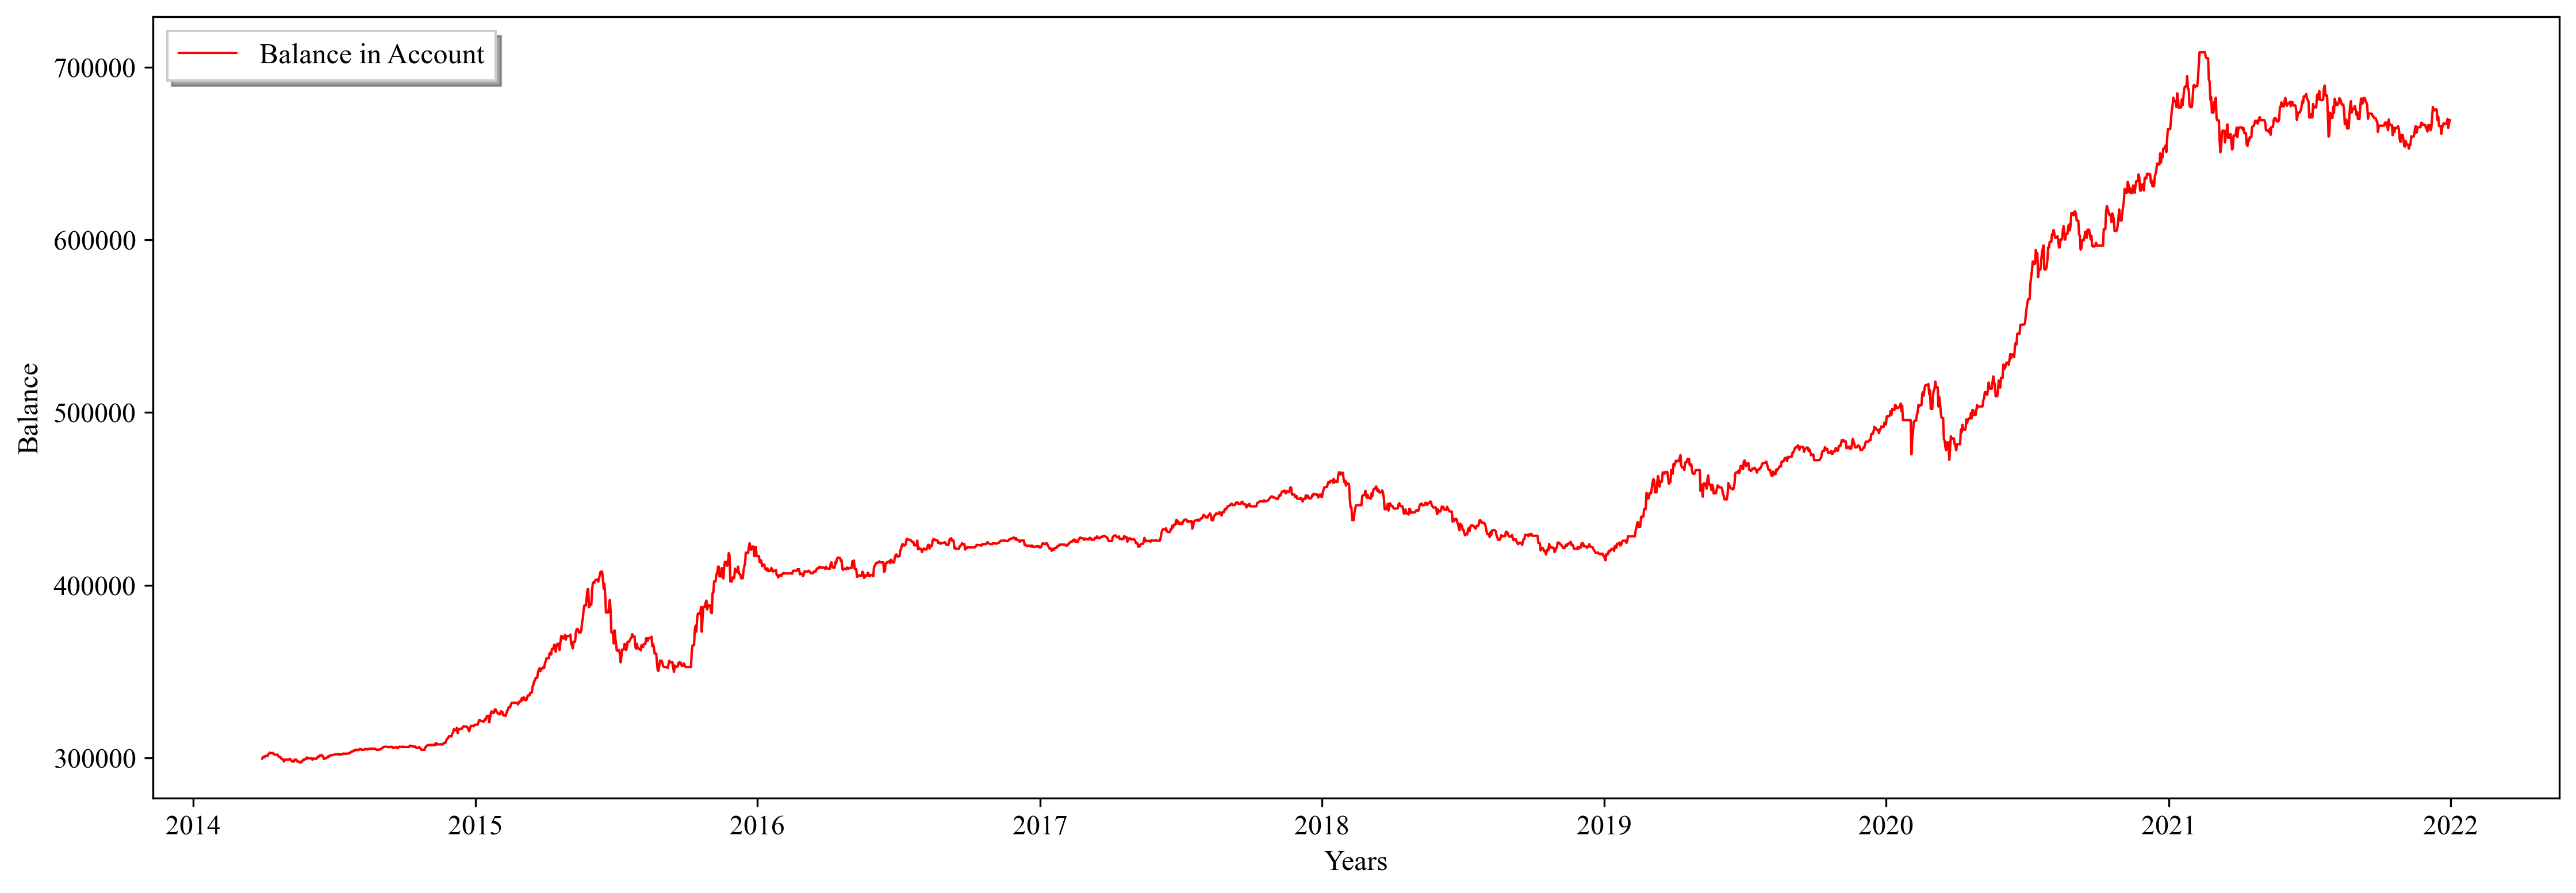

In [22]:
# plot
fig = plt.figure(figsize = (18,6),dpi = 300)
ax1 = fig.add_subplot(111)
ax1.plot(long_backtest_result.ACCOUNT_NAV, "-",color = "red",linewidth = 1,label = "Net Value")
# ax1.plot(short_backtest_result.ACCOUNT_NAV, "-",color = "#0000FF",linewidth = 1,label = "Net Value")
# ax1.plot(300000*long_backtest_result.ACCOUNT_NAV/short_backtest_result.ACCOUNT_NAV, "--",color = "orange",linewidth = 1,label = "Net Value")
plt.xticks(fontproperties='Times New Roman', size = 11.5)
plt.yticks(fontproperties='Times New Roman', size = 11.5)
ax1.set_ylabel("Balance",fontsize = 12)
ax1.set_xlabel("Years",fontsize = 12)
ax1.legend(["Balance in Account"], loc = 'upper left',fontsize = 12,shadow = "gray",fancybox = False)
plt.savefig("./Output/BalanceInAccount(SelfMade(Improved)).png")

#### 4.风险收益指标

In [19]:
# Sharpe
rf = 0.00011741094678452413
empyrical.sharpe_ratio(long_backtest_result.ACCOUNT_NAV.pct_change().dropna().values, risk_free = rf, period = 'daily', annualization = 365)

0.7225241743535992

In [20]:
# annual return
empyrical.annual_return(long_backtest_result.ACCOUNT_NAV.pct_change().dropna().values,period = 'daily',annualization = 365)

0.10916702485534757

In [21]:
# max drawdown
((long_backtest_result.ACCOUNT_NAV.cummax() - long_backtest_result.ACCOUNT_NAV)/(long_backtest_result.ACCOUNT_NAV.cummax())).max()

0.14228814225810066